In [450]:
import re
import os
import numpy as np
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from numpy import genfromtxt

#%% Import libraries
import torch
import torchmetrics
from torch.utils.data import DataLoader, TensorDataset
import os
from glob import glob
from sklearn.model_selection import train_test_split
import matplotlib.pylab as plt
from torch.optim.lr_scheduler import CosineAnnealingLR, MultiStepLR, StepLR, ReduceLROnPlateau

# Load training and test dataframes & TF-IDF matrices

In [451]:
# Load sentences and labels
train = pd.read_csv(r'Test_og_Train_df\train_dataframe.csv')
test = pd.read_csv(r'Test_og_Train_df\test_dataframe.csv')

In [452]:
train_labels = train["Labels"].tolist()

test_labels = test["Labels"].tolist()

In [453]:
train_tf_idf = pd.read_csv(r'DTTFIDFM_data\DTTFIDFM_train.csv')
test_tf_idf = pd.read_csv(r'DTTFIDFM_data\DTTFIDFM_test.csv')

train_tf_idf = train_tf_idf.drop('Unnamed: 0', axis=1)
test_tf_idf = test_tf_idf.drop('Unnamed: 0', axis=1)

In [454]:
train_tf_idf_numpy = train_tf_idf.to_numpy()
test_tf_idf_numpy = test_tf_idf.to_numpy()

In [455]:
# train_tf_idf_numpy

In [456]:
train_tf_idf_numpy.shape,test_tf_idf_numpy.shape

((8048, 24653), (2683, 24653))

# CNN

## Load SVD-matrix:

In [457]:
# Load SVD-matrix from csv-file
V_200 = genfromtxt('V200.csv', delimiter=',')

In [458]:
V_200

array([[-1.01522614e-01,  1.11495275e-01, -1.94767568e-01, ...,
         1.68914466e-02, -1.59969860e-02, -4.14657793e-02],
       [-8.21504456e-02,  5.38646152e-02, -5.83989941e-03, ...,
        -6.59796006e-03, -5.48038621e-03,  3.82854767e-02],
       [-9.73437764e-04,  7.31839751e-04, -1.98419009e-04, ...,
        -4.65777427e-04,  7.10243628e-04,  7.45946970e-04],
       ...,
       [-6.25781132e-04,  4.19897409e-04,  4.62287900e-05, ...,
         1.21027324e-04,  6.06961375e-06,  7.62899044e-04],
       [-5.13986347e-04,  4.40283044e-05,  2.03693542e-04, ...,
        -1.50341156e-04,  7.16554560e-05,  6.35583134e-04],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [459]:
V_200.shape

(24653, 200)

In [460]:
type(V_200)

numpy.ndarray

## Sentence LSA embedding

In [461]:
def sentence_LSA_embedding(TF_IDF_matrix_numpy, V_k):
    liste_LSA_vektorer = []
    for i in range(TF_IDF_matrix_numpy.shape[0]):
        lsa_vector = np.dot(TF_IDF_matrix_numpy[i], V_k)
        liste_LSA_vektorer.append(lsa_vector)
    return np.array(liste_LSA_vektorer)


In [462]:
train_lsa = sentence_LSA_embedding(train_tf_idf_numpy, V_200)
test_lsa = sentence_LSA_embedding(test_tf_idf_numpy, V_200)

## Make tensors

In [463]:
# Convert inputs
train_input_tensor = torch.tensor(train_lsa, dtype=torch.float32)  # Shape: (num_train_sentences, 200)
test_input_tensor = torch.tensor(test_lsa, dtype=torch.float32)    # Shape: (num_test_sentences, 200)

# Convert labels
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)  # Shape: (num_train_sentences,)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)    # Shape: (num_test_sentences,)

In [464]:
# Reshape the tensors for CNN input (adding the channel dimension)
train_input_tensor = train_input_tensor.unsqueeze(1)  # Shape: (num_train_sentences, 1, 200)
test_input_tensor = test_input_tensor.unsqueeze(1)    # Shape: (num_test_sentences, 1, 200)

In [465]:
train_input_tensor.shape, test_input_tensor.shape

(torch.Size([8048, 1, 200]), torch.Size([2683, 1, 200]))

In [466]:
batch_size = 300
# Create datasets
train_dataset = TensorDataset(train_input_tensor, train_labels_tensor)
test_dataset = TensorDataset(test_input_tensor, test_labels_tensor)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # Shuffle training data
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)   # No shuffle for testing

## Build the CNN

In [467]:
num_epochs = 120
learning_rate = 0.0007
weight_decay = 0.0001

In [468]:
#%% Device
# Run on GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"

In [469]:
#%% Neural network
net = torch.nn.Sequential(
    # ----------------------------
    # 1) Conv block: 1 -> 32 filters
    # With kernel_size=5, padding=2, the output length = input_length
    # If input length = 200:
    # After maxpool(kernel=2): length -> 200 // 2 = 100
    torch.nn.Conv1d(1, 16, kernel_size=3),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.05),
    torch.nn.MaxPool1d(kernel_size=2),           # -> [batch, 32, 100]

    # ----------------------------
    # 2) Conv block: 32 -> 64 filters
    # Length stays 100 before the pool. 
    # After maxpool(kernel=2): length -> 100 // 2 = 50
    # torch.nn.Conv1d(32, 64, kernel_size=5, padding=2),
    # torch.nn.BatchNorm1d(64),
    # torch.nn.ReLU(),
    # torch.nn.MaxPool1d(kernel_size=2),           # -> [batch, 64, 50]

    # # ----------------------------
    # # 3) Conv block: 64 -> 128 filters
    # # Length stays 50 before the pool. 
    # # After maxpool(kernel=2): length -> 50 // 2 = 25
    # torch.nn.Conv1d(64, 128, kernel_size=5, padding=2),
    # torch.nn.BatchNorm1d(128),
    # torch.nn.ReLU(),
    # torch.nn.MaxPool1d(kernel_size=2),           # -> [batch, 128, 25]

    # ----------------------------
    # 4) Dropout + Flatten + Fully Connected
    torch.nn.Flatten(),                          # -> [batch, 128*25 = 3200]
    torch.nn.Linear(16*99, 8*99),
    torch.nn.Dropout(p=0.5),                     # More moderate dropout
    torch.nn.ReLU(),
    torch.nn.Linear(8*99, 2),
).to(device)

In [470]:
#%% Loss and optimizer
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [471]:
# %% Load trained network from file
# net.load_state_dict(torch.load('netV5.pt'))

## Train

In [472]:
#%% Train
train_loss = {}
test_loss = {}
train_accuracy = {}
test_accuracy = {}
step = 0

test_labels_dronning = {}

test_labels_statsminister = {}

scheduler = StepLR(optimizer, 20, gamma=0.8)

for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        net.train()

        # Put data on GPU 
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        # Compute loss and take gradient step
        outputs = net(inputs)
        loss = loss_function(outputs, labels)

        loss.backward()
        optimizer.step()

        predicted = torch.argmax(outputs, dim=1)

        running_loss += loss.item()
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        # Print accuracy for epoch            
    epoch_loss = running_loss / len(train_loader)

    train_loss[epoch] = epoch_loss

    epoch_accuracy = 100 * correct / total

    train_accuracy[epoch] = epoch_accuracy

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Training loss: {epoch_loss:.4f}, Training accuracy: {epoch_accuracy:.2f}%")

    # Evaluate the model
    net.eval()
    correct = 0
    total = 0
    running_loss_test = 0.0

    with torch.no_grad():
        for inputs, labels in test_loader:
            # Put data on GPU 
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = net(inputs)
            
            predicted = torch.argmax(outputs, dim=1)

            loss = loss_function(outputs, labels)
            
            running_loss_test += loss.item()

            # Count correct predictions
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            if labels == 0 and predicted == labels:
                test_labels_dronning[inputs] = 1
            else:
                test_labels_dronning[inputs] = 0

            if labels == 1 and predicted == labels:
                test_labels_statsminister[inputs] = 1
            else:
                test_labels_statsminister[inputs] = 0

        epoch_loss_test = running_loss_test / len(test_loader)
        test_loss[epoch] = epoch_loss_test

    test_accuracy_score = 100 * correct / total
    
    dronning_label_accuracy = 100 * test_labels_dronning / total



    test_accuracy[epoch] = test_accuracy_score

    print(f"Test loss: {epoch_loss:.4f}, Test accuracy: {test_accuracy_score:.2f}%")
    print()

    scheduler.step(epoch_loss_test)


RuntimeError: Boolean value of Tensor with more than one value is ambiguous

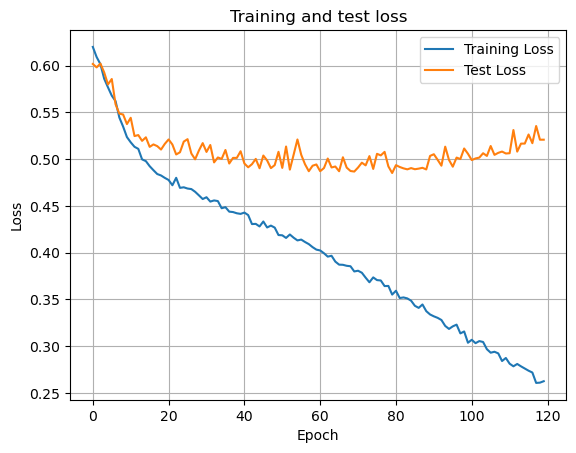

In [ ]:
plt.plot(train_loss.values(), label="Training Loss")
plt.plot(test_loss.values(), label="Test Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and test loss")
plt.grid(True)

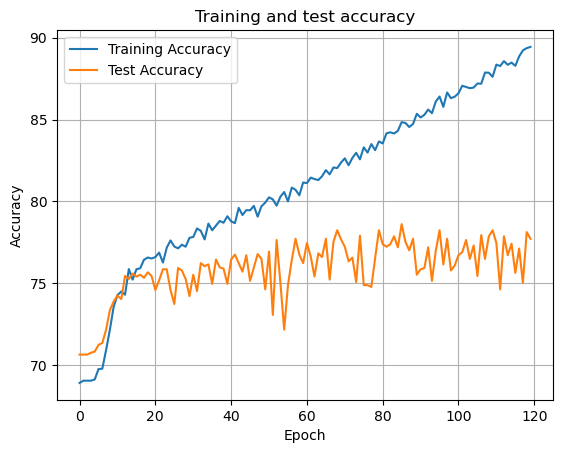

In [437]:
plt.plot(train_accuracy.values(), label="Training Accuracy")
plt.plot(test_accuracy.values(), label="Test Accuracy")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and test accuracy")
plt.grid(True)

In [411]:
# %% Save the trained model
# torch.save(net.state_dict(), 'netV11.pt')